# XAI | Mechanistic Interpretability


Description:

by Christian Moreira(chris.moreira@duke.edu)

[![GitHub Repo](https://img.shields.io/badge/GitHub-Repo-black.svg?logo=github&style=for-the-badge)](https://github.com/U1186204/Mechanistic-Interpretability/tree/main)

[![Open In Colab](https://img.shields.io/badge/Open%20In-Colab-F9AB00.svg?logo=googlecolab&style=for-the-badge)](https://colab.research.google.com/github/U1186204/Mechanistic-Interpretability/blob/main/main.ipynb)



### Part 1: Model SetUp & Training

### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import string
import matplotlib.pyplot as plt

### Data Generation

In [2]:
SEQ_LENGTH = 5
VOCAB = string.ascii_lowercase
VOCAB_SIZE = len(VOCAB)

char_to_idx = {char: i for i, char in enumerate(VOCAB)}
idx_to_char = {i: char for i, char in enumerate(VOCAB)}

def one_hot_encode(sequence, vocab_size):
    tensor = torch.zeros(len(sequence), vocab_size)
    for i, char in enumerate(sequence):
        tensor[i, char_to_idx[char]] = 1
    return tensor

def generate_data(n_samples, seq_length):
    X = []
    y = []
    for _ in range(n_samples):
        input_seq = ''.join(random.choices(VOCAB, k=seq_length))
        output_seq = input_seq[::-1]

        one_hot_input = one_hot_encode(input_seq, VOCAB_SIZE)
        X.append(one_hot_input.view(-1))

        y.append(torch.tensor([char_to_idx[char] for char in output_seq], dtype=torch.long))

    return torch.stack(X), torch.stack(y)

### Generating + Loading Data

In [3]:
INPUT_DIM = SEQ_LENGTH * VOCAB_SIZE
HIDDEN_DIM = 20
OUTPUT_DIM = SEQ_LENGTH * VOCAB_SIZE
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train, y_train = generate_data(20000, SEQ_LENGTH)
X_val, y_val = generate_data(2000, SEQ_LENGTH)

X_train = X_train.to(DEVICE)
y_train = y_train.to(DEVICE)
X_val = X_val.to(DEVICE)
y_val = y_val.to(DEVICE)

print(f"Device: {DEVICE}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

Device: cpu
X_train shape: torch.Size([20000, 130])
y_train shape: torch.Size([20000, 5])


### Defining Tiny MLP Model



In [4]:
class ReversingMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        out = self.fc2(h)
        return out, h

### Instantiate Model and Optimizer

In [5]:
model = ReversingMLP(INPUT_DIM, HIDDEN_DIM, OUTPUT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)

ReversingMLP(
  (fc1): Linear(in_features=130, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=130, bias=True)
)


### Training Loop

In [6]:
N_EPOCHS = 3000
train_losses = []

for epoch in range(N_EPOCHS):
    model.train()

    output, _ = model(X_train)

    output_for_loss = output.view(-1, VOCAB_SIZE)
    target_for_loss = y_train.view(-1)

    loss = criterion(output_for_loss, target_for_loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    if (epoch+1) % 200 == 0:
        print(f'Epoch: {epoch+1:04d} | Train Loss: {loss.item():.4f}')

Epoch: 0200 | Train Loss: 2.2771
Epoch: 0400 | Train Loss: 1.4007
Epoch: 0600 | Train Loss: 1.1373
Epoch: 0800 | Train Loss: 0.9796
Epoch: 1000 | Train Loss: 0.8200
Epoch: 1200 | Train Loss: 0.6240
Epoch: 1400 | Train Loss: 0.4068
Epoch: 1600 | Train Loss: 0.2330
Epoch: 1800 | Train Loss: 0.1311
Epoch: 2000 | Train Loss: 0.0770
Epoch: 2200 | Train Loss: 0.0481
Epoch: 2400 | Train Loss: 0.0321
Epoch: 2600 | Train Loss: 0.0227
Epoch: 2800 | Train Loss: 0.0168
Epoch: 3000 | Train Loss: 0.0128


# Exploration & Explanation

### Training Loss

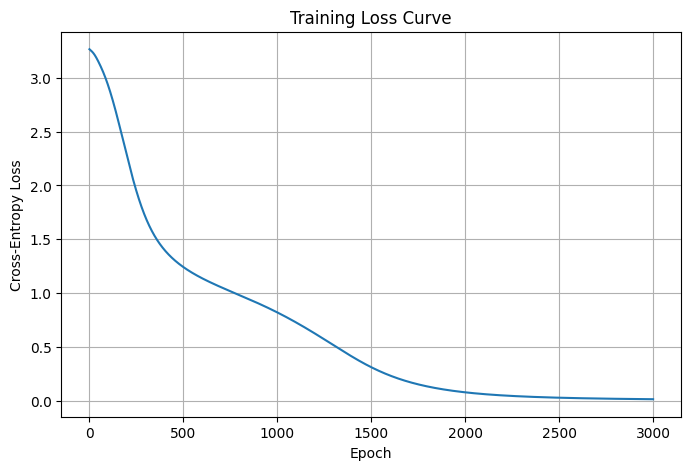

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses)
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

**Interpretation**

- The model's training loss decreased over 3000 epochs, starting above 3 and ending near 0

- The fastest learning rates(or loss reduction) occurred early in the training in the first 1500 epochs.

- By the end of training the loss converged and flattened out; This suggests the model had achieved its peak performance and would not benefit much with further training.

### Evaluation Fucntion

In [8]:
def calculate_val_accuracy(model, X_val, y_val):
    model.eval()
    with torch.no_grad():
        val_output, _ = model(X_val)
        val_output = val_output.view(-1, VOCAB_SIZE)
        val_target = y_val.view(-1)

        preds = val_output.argmax(dim=1)
        correct = (preds == val_target).sum().item()
        total = val_target.shape[0]

    return 100 * (correct / total)

def predict_sequence(model, input_str, device):
    model.eval()
    with torch.no_grad():
        input_tensor = one_hot_encode(input_str, VOCAB_SIZE).view(1, -1).to(device)
        output, hidden_acts = model(input_tensor)

        output_logits = output.view(SEQ_LENGTH, VOCAB_SIZE)
        preds_idx = output_logits.argmax(dim=1).cpu().numpy()

        output_str = ''.join([idx_to_char[idx] for idx in preds_idx])

    return output_str, hidden_acts.squeeze()

def get_char_accuracy(s1, s2):
    return sum(c1 == c2 for c1, c2 in zip(s1, s2))

### Runnning Evaluation

In [10]:
val_accuracy = calculate_val_accuracy(model, X_val, y_val)
print(f'Validation Character Accuracy: {val_accuracy:.2f}%')

print("\n--- Sample Predictions ---")
test_words = ['hello', 'world', 'young', 'three', 'steak']
for word in test_words:
    prediction, _ = predict_sequence(model, word, DEVICE)
    print(f"Input: '{word}' | Pred: '{prediction}' | True: '{word[::-1]}'")

Validation Character Accuracy: 100.00%

--- Sample Predictions ---
Input: 'hello' | Pred: 'olleh' | True: 'olleh'
Input: 'world' | Pred: 'dlrow' | True: 'dlrow'
Input: 'young' | Pred: 'gnuoy' | True: 'gnuoy'
Input: 'three' | Pred: 'eerht' | True: 'eerht'
Input: 'steak' | Pred: 'kaets' | True: 'kaets'


**Interpretation**
* The model achieves 100% accuracy on the validation examples

* The sample show the model learned the task to reverse words

* This suggests the model generalized the problem of reversing a 5 character string well

### Visulizing Input Weights

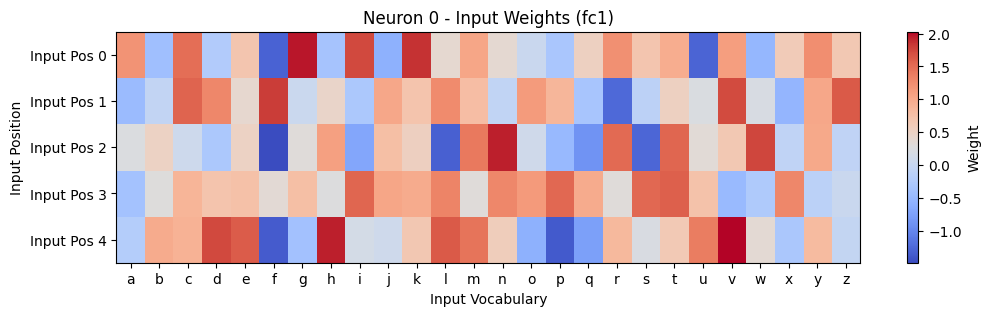

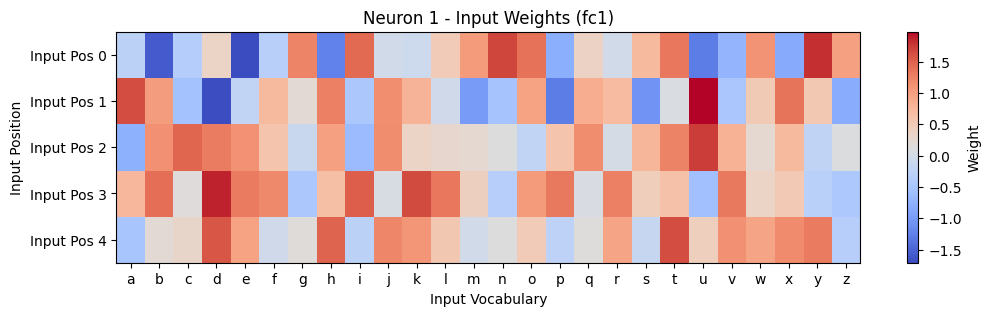

In [11]:
fc1_weights = model.fc1.weight.data.T.cpu()

def plot_neuron_input_weights(neuron_idx):
    neuron_weights = fc1_weights[:, neuron_idx]
    neuron_weights_reshaped = neuron_weights.view(SEQ_LENGTH, VOCAB_SIZE)

    plt.figure(figsize=(12, 3))
    plt.imshow(neuron_weights_reshaped, cmap='coolwarm', aspect='auto')
    plt.xticks(range(VOCAB_SIZE), VOCAB)
    plt.yticks(range(SEQ_LENGTH), [f'Input Pos {i}' for i in range(SEQ_LENGTH)])
    plt.xlabel("Input Vocabulary")
    plt.ylabel("Input Position")
    plt.title(f"Neuron {neuron_idx} - Input Weights (fc1)")
    plt.colorbar(label="Weight")
    plt.show()

plot_neuron_input_weights(neuron_idx=0)
plot_neuron_input_weights(neuron_idx=1)

**Interpretation**

- Here we see the input weights for Neuron 0 and 1. The heatmat helps visualizing how the neuron excites in red or inhibits in blue each character at each of the 5 input positions

- This neuron has a complex, spread out pattern, responding to different characters across the 5 letter positions. An example is in euron 0 it likes 'i' at position 0 but dislikes 'f' at that same position.

- For neuron 1, it dislikes 'b' and 'e' at position 0, and it likes 'n' and 'y' in that position.

### Visualizing Output Weights

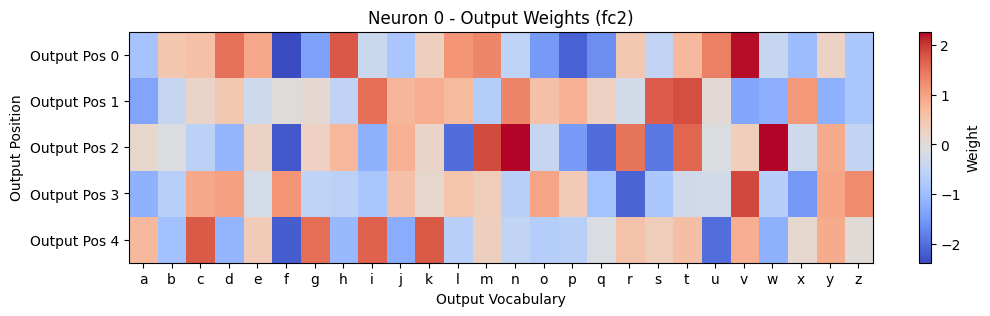

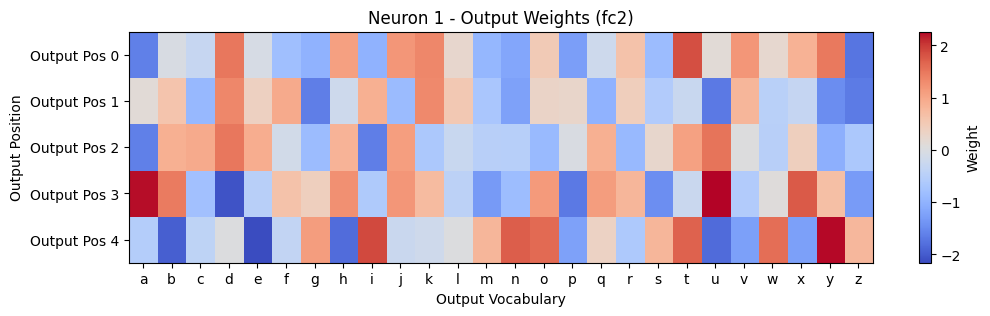

In [12]:
fc2_weights = model.fc2.weight.data.cpu()
fc2_weights_reshaped = fc2_weights.view(SEQ_LENGTH, VOCAB_SIZE, HIDDEN_DIM)

def plot_neuron_output_weights(neuron_idx):
    neuron_output_weights = fc2_weights_reshaped[:, :, neuron_idx]

    plt.figure(figsize=(12, 3))
    plt.imshow(neuron_output_weights, cmap='coolwarm', aspect='auto')
    plt.xticks(range(VOCAB_SIZE), VOCAB)
    plt.yticks(range(SEQ_LENGTH), [f'Output Pos {i}' for i in range(SEQ_LENGTH)])
    plt.xlabel("Output Vocabulary")
    plt.ylabel("Output Position")
    plt.title(f"Neuron {neuron_idx} - Output Weights (fc2)")
    plt.colorbar(label="Weight")
    plt.show()

plot_neuron_output_weights(neuron_idx=0)
plot_neuron_output_weights(neuron_idx=1)

**Interpretation**

- the heatmap visualizes the output weights for neuron 0. It votes for each charachter at each output position

- red suggests a favoritism at a given position in that neuron and dark blue suggests thet neuron votes against that charachter in a given position

- FOr example at neuron 1 position 3, the model likes 'd', but does not like 'u'.

### Neuron Abalation

In [13]:
test_input_str = 'abcde'
true_output = test_input_str[::-1]
baseline_pred, _ = predict_sequence(model, test_input_str, DEVICE)
baseline_acc = get_char_accuracy(baseline_pred, true_output)

print(f"--- Ablation Test on Input: '{test_input_str}' ---")
print(f"Baseline Pred: '{baseline_pred}' | Baseline Acc: {baseline_acc}/{SEQ_LENGTH}")

def get_ablation_pred(model, input_str, neuron_to_ablate, device):
    model.eval()
    with torch.no_grad():
        input_tensor = one_hot_encode(input_str, VOCAB_SIZE).view(1, -1).to(device)

        h = F.relu(model.fc1(input_tensor))
        h[:, neuron_to_ablate] = 0.0
        output = model.fc2(h)

        output_logits = output.view(SEQ_LENGTH, VOCAB_SIZE)
        preds_idx = output_logits.argmax(dim=1).cpu().numpy()
        output_str = ''.join([idx_to_char[idx] for idx in preds_idx])

    return output_str

accuracy_drops = []
for i in range(HIDDEN_DIM):
    ablated_pred = get_ablation_pred(model, test_input_str, i, DEVICE)
    ablated_acc = get_char_accuracy(ablated_pred, true_output)
    accuracy_drops.append(baseline_acc - ablated_acc)

--- Ablation Test on Input: 'abcde' ---
Baseline Pred: 'edcba' | Baseline Acc: 5/5


### Ablation Plot

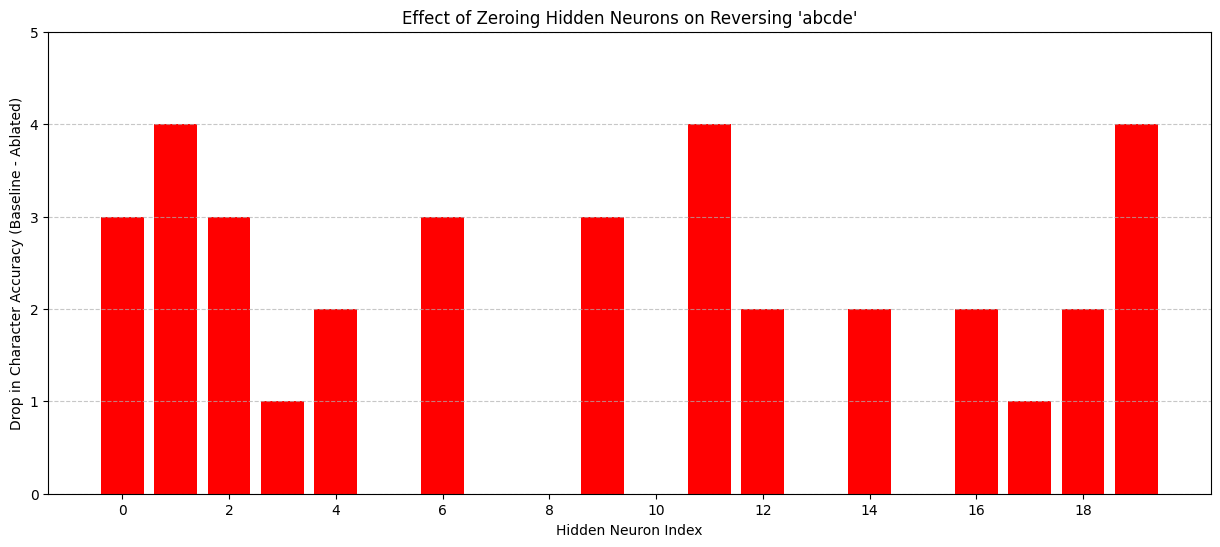

Ablating Neuron 0 caused accuracy to drop by 3 characters.
Ablating Neuron 1 caused accuracy to drop by 4 characters.
Ablating Neuron 2 caused accuracy to drop by 3 characters.
Ablating Neuron 3 caused accuracy to drop by 1 characters.
Ablating Neuron 4 caused accuracy to drop by 2 characters.
Ablating Neuron 6 caused accuracy to drop by 3 characters.
Ablating Neuron 9 caused accuracy to drop by 3 characters.
Ablating Neuron 11 caused accuracy to drop by 4 characters.
Ablating Neuron 12 caused accuracy to drop by 2 characters.
Ablating Neuron 14 caused accuracy to drop by 2 characters.
Ablating Neuron 16 caused accuracy to drop by 2 characters.
Ablating Neuron 17 caused accuracy to drop by 1 characters.
Ablating Neuron 18 caused accuracy to drop by 2 characters.
Ablating Neuron 19 caused accuracy to drop by 4 characters.


In [14]:
plt.figure(figsize=(15, 6))
colors = ['red' if d > 0 else 'gray' for d in accuracy_drops]
plt.bar(range(HIDDEN_DIM), accuracy_drops, color=colors)

plt.xlabel("Hidden Neuron Index")
plt.ylabel("Drop in Character Accuracy (Baseline - Ablated)")
plt.title(f"Effect of Zeroing Hidden Neurons on Reversing '{test_input_str}'")
plt.xticks(range(0, HIDDEN_DIM, 2))
plt.yticks(range(SEQ_LENGTH + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

for i, drop in enumerate(accuracy_drops):
    if drop > 0:
        print(f"Ablating Neuron {i} caused accuracy to drop by {drop} characters.")

**Interpretation**
- Neurons 1, 11, and 19 are the most important for this mini MLP model;  Removing any of them caused the model to get 4 out of 5 characters incorrect.

- The reversal task suggests at least 14 different neurons are important for correctly processing our 5 letter words and write them in reverse

- We see that in general the model's knowledge is not specific to one single position, instead, it seems quite spread out across all 20 input neurons.

### Reflection

* What did you learn about how your model works?

Answer: I learned that at each neuron we could test to see neuron importance in a model. I think this is highly applicable for further developing neural networks in the future. It leads me in a developer place to wonder if a model needs as much complexity with many neurons if for example, only one neuron is really impacting the output.

* What was confusing, surprising, or challenging to interpret?

Answer: Something a bit confusing/chalenging is how not a single neuron but all neurons interact to form accurate results at the very end. Since all neurons seemed relatively relevant, I wonder if all of them working concomitantly lead to the model to follow linguistic patterns/rules that the English/Latin language adopts.

- What’s one thing you wish you could
understand better or explore further?

Answer: In Large Language Models I think it would be interesting to see if performing these neuron abalations could lead to LLMs becoming more efficient and more accurate. Efficient in a sense that maybe not as many neurons are needed to provide a 'good enough' answer. And accurate to the extent that in a heatmap, it would be interesting to visualize how one word followd the other to form a solid cohesive english sentence.